In [8]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
sns.set_style('darkgrid')

In [9]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from cVAE_architecture import cVAE, loss_vae
from cVAE_train_utils import train_cVAE

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
batch_size = 128
cmap = plt.cm.get_cmap('viridis', 10)

## MNIST

In [10]:
# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./mnist_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(
    root='./mnist_data', train=False, transform=transform, download=True)

# Create data loaders to handle batch processing
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])


beta = 1e-20

<Figure size 432x288 with 0 Axes>

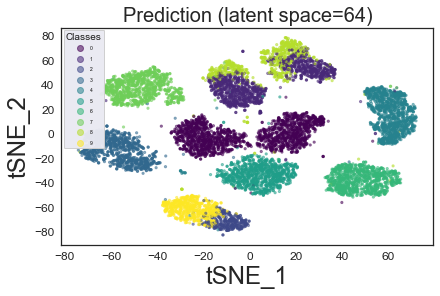

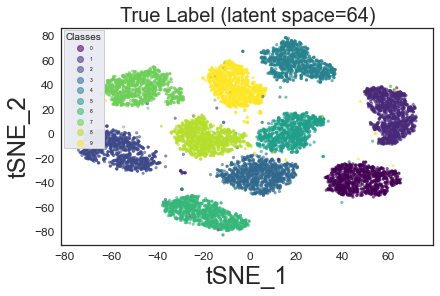

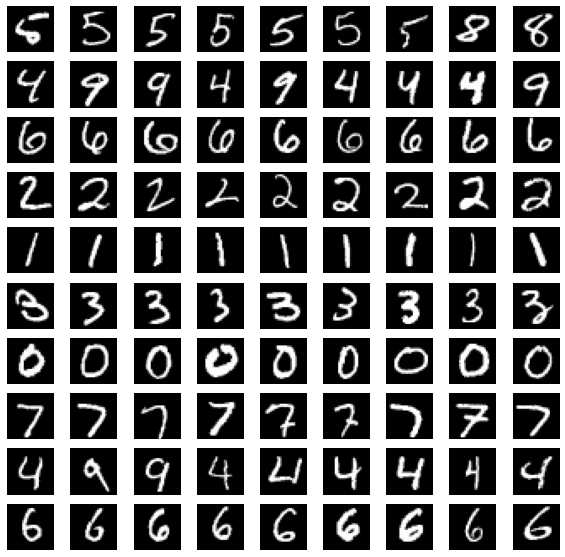

class_equivalence:  [8. 9. 6. 2. 1. 3. 0. 7. 4. 6.]
Accuracy: 0.8317, Silhouette: 0.1333, DB: 2.1815, CH: 714.0001


In [11]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_0_epochs_20.pth',map_location=torch.device('cpu')))

z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")

# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_0 = accuracy_score(y_test, y_pred)

s_0 = silhouette_score(z_test, clustering_labels)
db_0 = davies_bouldin_score(z_test, clustering_labels)
ch_0 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_0}, Silhouette: {s_0:.4f}, DB: {db_0:.4f}, CH: {ch_0:.4f}")

beta = 1e-5

<Figure size 432x288 with 0 Axes>

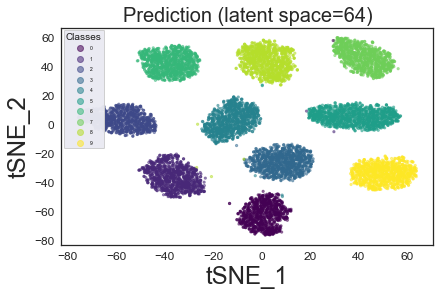

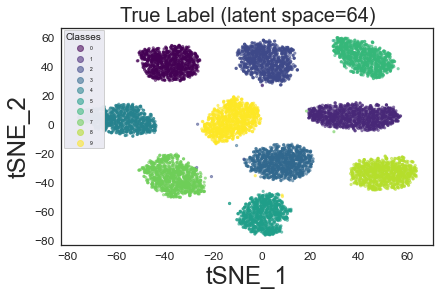

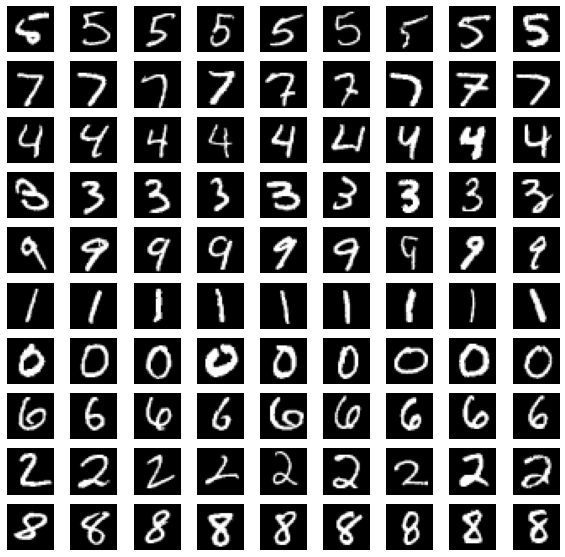

class_equivalence:  [5. 7. 4. 3. 9. 1. 0. 6. 2. 8.]
Accuracy: 1.0, Silhouette: 0.1705, DB: 1.9654, CH: 721.0605


In [12]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_1e-05_epochs_20.pth',map_location=torch.device('cpu')))

z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")

# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_000001 = accuracy_score(y_test, y_pred)

s_000001 = silhouette_score(z_test, clustering_labels)
db_000001 = davies_bouldin_score(z_test, clustering_labels)
ch_000001 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_000001}, Silhouette: {s_000001:.4f}, DB: {db_000001:.4f}, CH: {ch_000001:.4f}")

beta = 0.01

<Figure size 432x288 with 0 Axes>

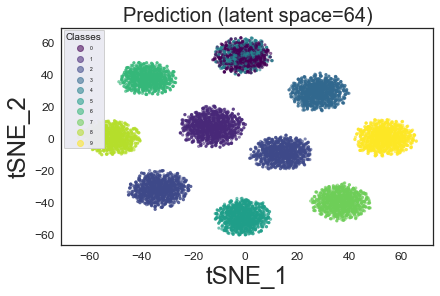

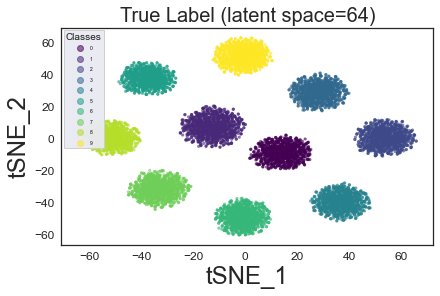

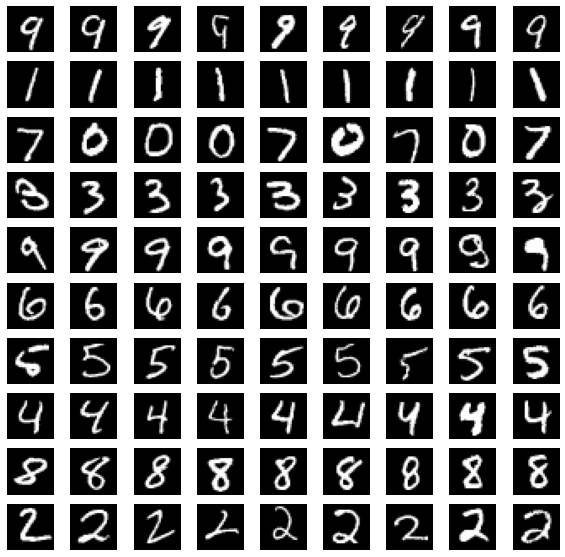

class_equivalence:  [9. 1. 7. 3. 9. 6. 5. 4. 8. 2.]
Accuracy: 0.902, Silhouette: 0.1182, DB: 3.0133, CH: 426.2873


In [13]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_0.01_epochs_20.pth',map_location=torch.device('cpu')))

z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")

# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()
class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_001 = accuracy_score(y_test, y_pred)

s_001 = silhouette_score(z_test, clustering_labels)
db_001 = davies_bouldin_score(z_test, clustering_labels)
ch_001 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_001}, Silhouette: {s_001:.4f}, DB: {db_001:.4f}, CH: {ch_001:.4f}")

beta = 1



<Figure size 432x288 with 0 Axes>

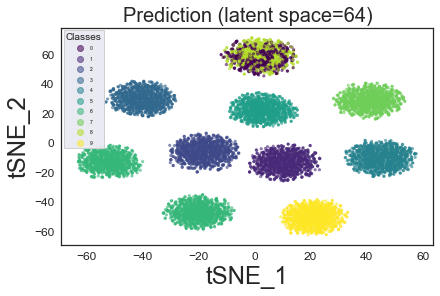

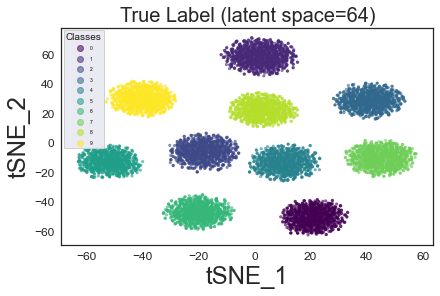

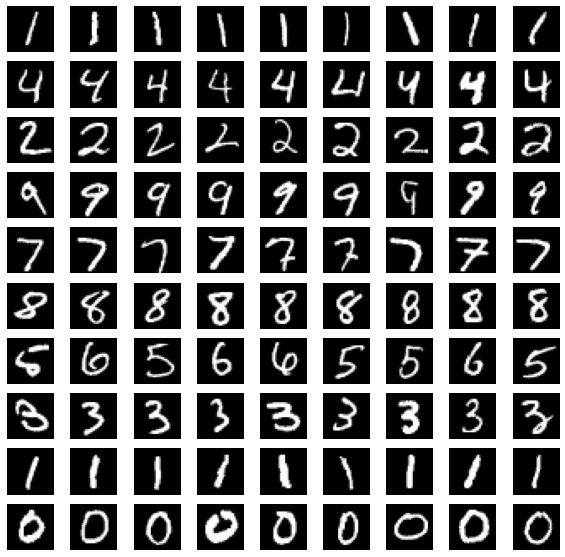

class_equivalence:  [1. 4. 2. 9. 7. 8. 6. 3. 1. 0.]
Accuracy: 0.9108, Silhouette: 0.1017, DB: 3.2140, CH: 398.3638


In [14]:

autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_1_epochs_20.pth',map_location=torch.device('cpu')))


z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")
# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_1 = accuracy_score(y_test, y_pred)

s_1 = silhouette_score(z_test, clustering_labels)
db_1 = davies_bouldin_score(z_test, clustering_labels)
ch_1 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_1}, Silhouette: {s_1:.4f}, DB: {db_1:.4f}, CH: {ch_1:.4f}")

beta = 100

<Figure size 432x288 with 0 Axes>

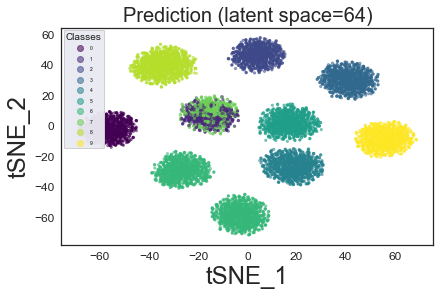

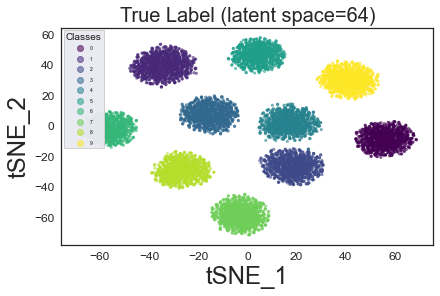

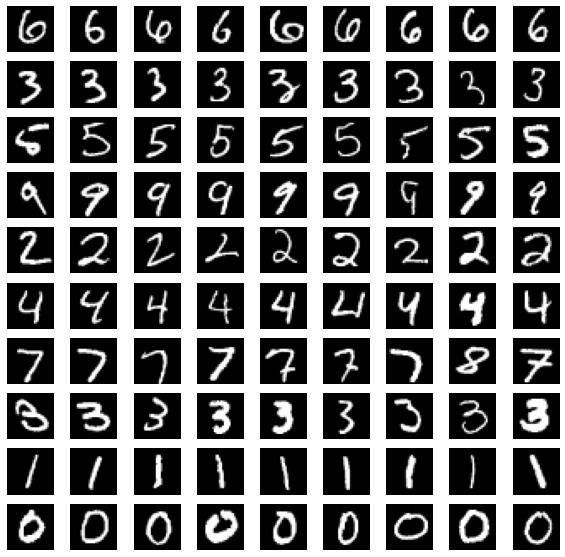

class_equivalence:  [6. 3. 5. 9. 2. 4. 7. 3. 1. 0.]
Accuracy: 0.9026, Silhouette: 0.1014, DB: 3.0518, CH: 397.7461


In [15]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_100.0_epochs_20.pth',map_location=torch.device('cpu')))

z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")

# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()
class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_100 = accuracy_score(y_test, y_pred)

s_100 = silhouette_score(z_test, clustering_labels)
db_100 = davies_bouldin_score(z_test, clustering_labels)
ch_100 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_100}, Silhouette: {s_100:.4f}, DB: {db_100:.4f}, CH: {ch_100:.4f}")

beta = 1e5

<Figure size 432x288 with 0 Axes>

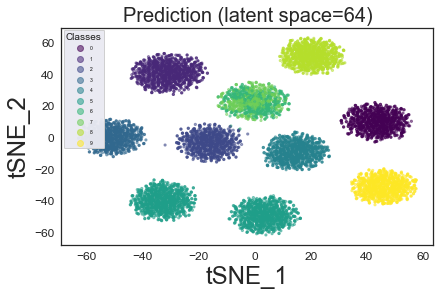

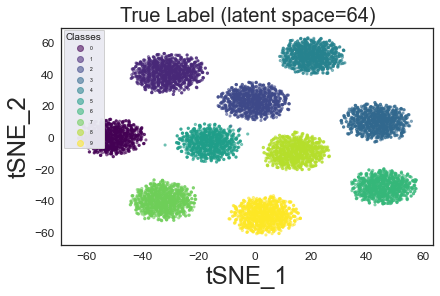

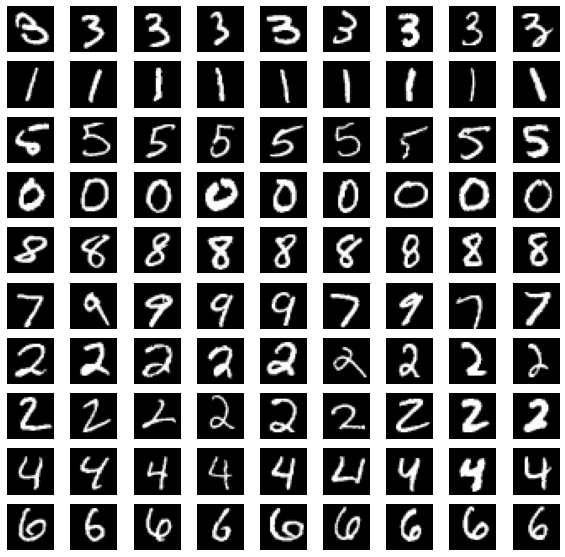

class_equivalence:  [3. 1. 5. 0. 8. 7. 2. 2. 4. 6.]
Accuracy: 0.8991, Silhouette: 0.1038, DB: 3.0784, CH: 407.9379


In [16]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_100000.0_epochs_20.pth',map_location=torch.device('cpu')))


z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")


# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_100000 = accuracy_score(y_test, y_pred)

s_100000 = silhouette_score(z_test, clustering_labels)
db_100000 = davies_bouldin_score(z_test, clustering_labels)
ch_100000 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_100000}, Silhouette: {s_100000:.4f}, DB: {db_100000:.4f}, CH: {ch_100000:.4f}")

beta = 1e9

<Figure size 432x288 with 0 Axes>

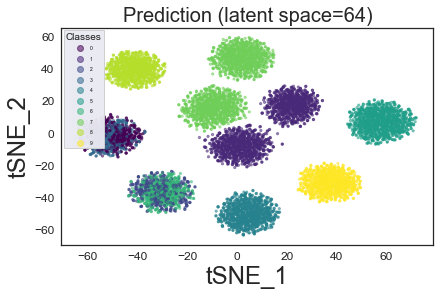

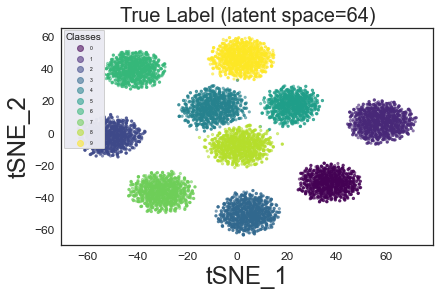

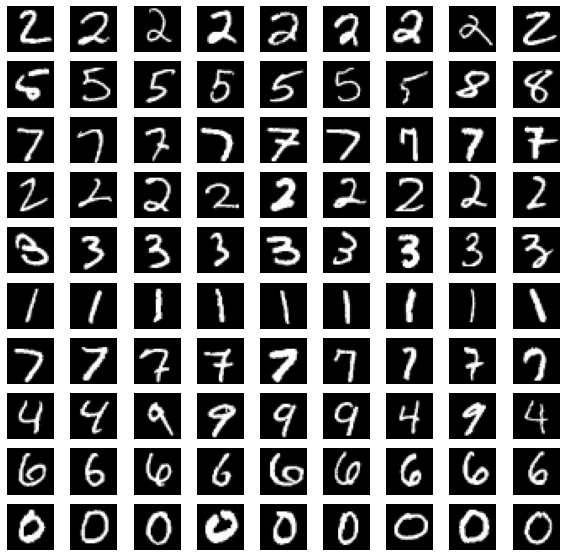

class_equivalence:  [2. 8. 7. 2. 3. 1. 7. 9. 6. 0.]
Accuracy: 0.8126, Silhouette: 0.0848, DB: 3.7629, CH: 345.0209


In [17]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16,input_size=28)
autoencoder_cvae.load_state_dict(torch.load('./models_Mnist/cVAE_Name_zdim_16_beta_10000000000.0_epochs_20.pth',map_location=torch.device('cpu')))


z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")


# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(10,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        #axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

class_equivalence = compute_most_represented_class_per_cluster(
    clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_e9 = accuracy_score(y_test, y_pred)

s_e9 = silhouette_score(z_test, clustering_labels)
db_e9 = davies_bouldin_score(z_test, clustering_labels)
ch_e9 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Accuracy: {acc_e9}, Silhouette: {s_e9:.4f}, DB: {db_e9:.4f}, CH: {ch_e9:.4f}")

In [34]:
print(" ")

data = {'beta': ['1e-20','1e-5', '00.1', '1', '100','1e5','1e9'],
        'Accuracy': [acc_0, acc_000001, acc_001, acc_1, acc_100, acc_100000, acc_e9],
        
        'Silhouette': [s_0, s_000001, s_001, s_1, s_100, s_100000, s_e9],
        
        'DB': [db_0, db_000001, db_001, db_1, db_100, db_100000, db_e9],

        'CH': [ch_0, ch_000001, ch_001, ch_1, ch_100, ch_100000, ch_e9]}

df = pd.DataFrame(data)

print(df.to_markdown(index=False))

 
|       beta |   Accuracy |   Silhouette |      DB |      CH |
|-----------:|-----------:|-------------:|--------:|--------:|
|      1e-20 |     0.8317 |    0.133296  | 2.1815  | 714     |
|      1e-05 |     1      |    0.170485  | 1.96544 | 721.06  |
|      0.1   |     0.902  |    0.118167  | 3.01326 | 426.287 |
|      1     |     0.9108 |    0.101669  | 3.21399 | 398.364 |
|    100     |     0.9026 |    0.101368  | 3.05179 | 397.746 |
| 100000     |     0.8991 |    0.103771  | 3.07838 | 407.938 |
|      1e+09 |     0.8126 |    0.0847798 | 3.76288 | 345.021 |


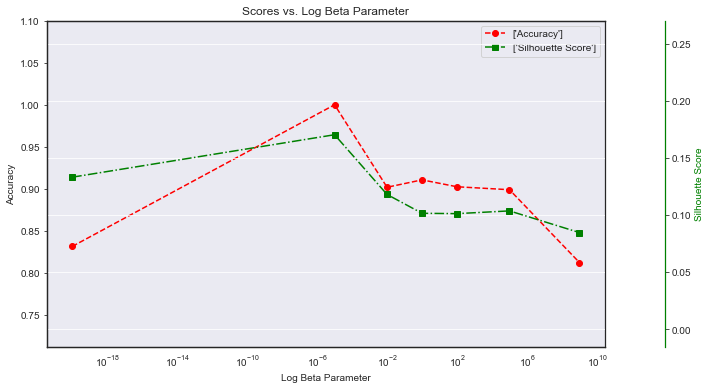

In [33]:
beta_values = [1e-20,1e-5, 0.01, 1, 100,1e5,1e9]
acc_scores = [acc_0, acc_000001, acc_001, acc_1, acc_100, acc_100000, acc_e9]
s_scores = [s_0, s_000001, s_001, s_1, s_100, s_100000, s_e9]
db_scores = [db_0, db_000001, db_001, db_1, db_100, db_100000, db_e9]
ch_scores = [ch_0, ch_000001, ch_001, ch_1, ch_100, ch_100000, ch_e9]

# Create plots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy Score (Plotted first)
ax1.plot(beta_values, acc_scores, label='Accuracy', marker='o', color='r', linestyle='--')
ax1.set_xscale('log')  # Set x-axis to logarithmic scale
ax1.set_xlabel('Log Beta Parameter')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(min(acc_scores) - 0.1, max(acc_scores) + 0.1)
ax1.grid(False)
ax1.legend()

# Silhouette Score
ax2 = ax1.twinx()
ax2.plot(beta_values, s_scores, label='Silhouette Score', marker='s', color='g', linestyle='-.')
ax2.set_ylabel('Silhouette Score', color='g')
ax2.set_ylim(min(s_scores) - 0.1, max(s_scores) + 0.1)

# # DB Score
# ax3 = ax1.twinx()
# ax3.plot(beta_values, db_scores, label='DB Score', marker='^', color='y', linestyle='--')
# ax3.set_ylabel('DB Score', color='r')
# ax3.set_ylim(min(db_scores) - 0.4, max(db_scores) + 0.4)

# # CH Score
# ax4 = ax1.twinx()
# ax4.plot(beta_values, ch_scores, label='CH Score', marker='D', color='b', linestyle=':')
# ax4.set_ylabel('CH Score', color='b')
# ax4.set_ylim(min(ch_scores) - 40, max(ch_scores) + 40)

# Adjust y-axis positions for the second, third, and fourth y-axes
ax2.spines['right'].set_position(('outward', 60))
ax2.spines['right'].set_color('g')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

lines = lines1 + lines2 
labels = (labels1,labels2)
ax1.legend(lines, labels, loc='best')

plt.title('Scores vs. Log Beta Parameter')
plt.show()